In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [32]:
df=pd.read_csv("PDB_Load_History(2003).csv")

In [33]:
df.dtypes

date            object
year             int64
month            int64
day              int64
weekday          int64
hour             int64
demand         float64
temperature      int64
dtype: object

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103776 entries, 0 to 103775
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         103776 non-null  object 
 1   year         103776 non-null  int64  
 2   month        103776 non-null  int64  
 3   day          103776 non-null  int64  
 4   weekday      103776 non-null  int64  
 5   hour         103776 non-null  int64  
 6   demand       103776 non-null  float64
 7   temperature  103776 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 6.3+ MB


In [35]:
df

,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29
...,...,...,...,...,...,...,...,...
103771,12/31/2014,2014,12,31,4,20,16955.0,22
103772,12/31/2014,2014,12,31,4,21,16243.0,21
103773,12/31/2014,2014,12,31,4,22,15525.0,21
103774,12/31/2014,2014,12,31,4,23,14759.0,18


In [36]:
df["DateTime"] = pd.to_datetime(df.date.astype(str) + ' ' + (df.hour-1).astype(str), format='%m/%d/%Y %H')
df["DateTime"]=pd.to_datetime(df["DateTime"])
df.set_index("DateTime",inplace=True)
df

,date,year,month,day,weekday,hour,demand,temperature
DateTime,,,,,,,,
2003-03-01 00:00:00,3/1/2003,2003,3,1,7,1,12863.0,29
2003-03-01 01:00:00,3/1/2003,2003,3,1,7,2,12389.0,28
2003-03-01 02:00:00,3/1/2003,2003,3,1,7,3,12155.0,29
2003-03-01 03:00:00,3/1/2003,2003,3,1,7,4,12072.0,27
2003-03-01 04:00:00,3/1/2003,2003,3,1,7,5,12160.0,29
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,12/31/2014,2014,12,31,4,20,16955.0,22
2014-12-31 20:00:00,12/31/2014,2014,12,31,4,21,16243.0,21
2014-12-31 21:00:00,12/31/2014,2014,12,31,4,22,15525.0,21


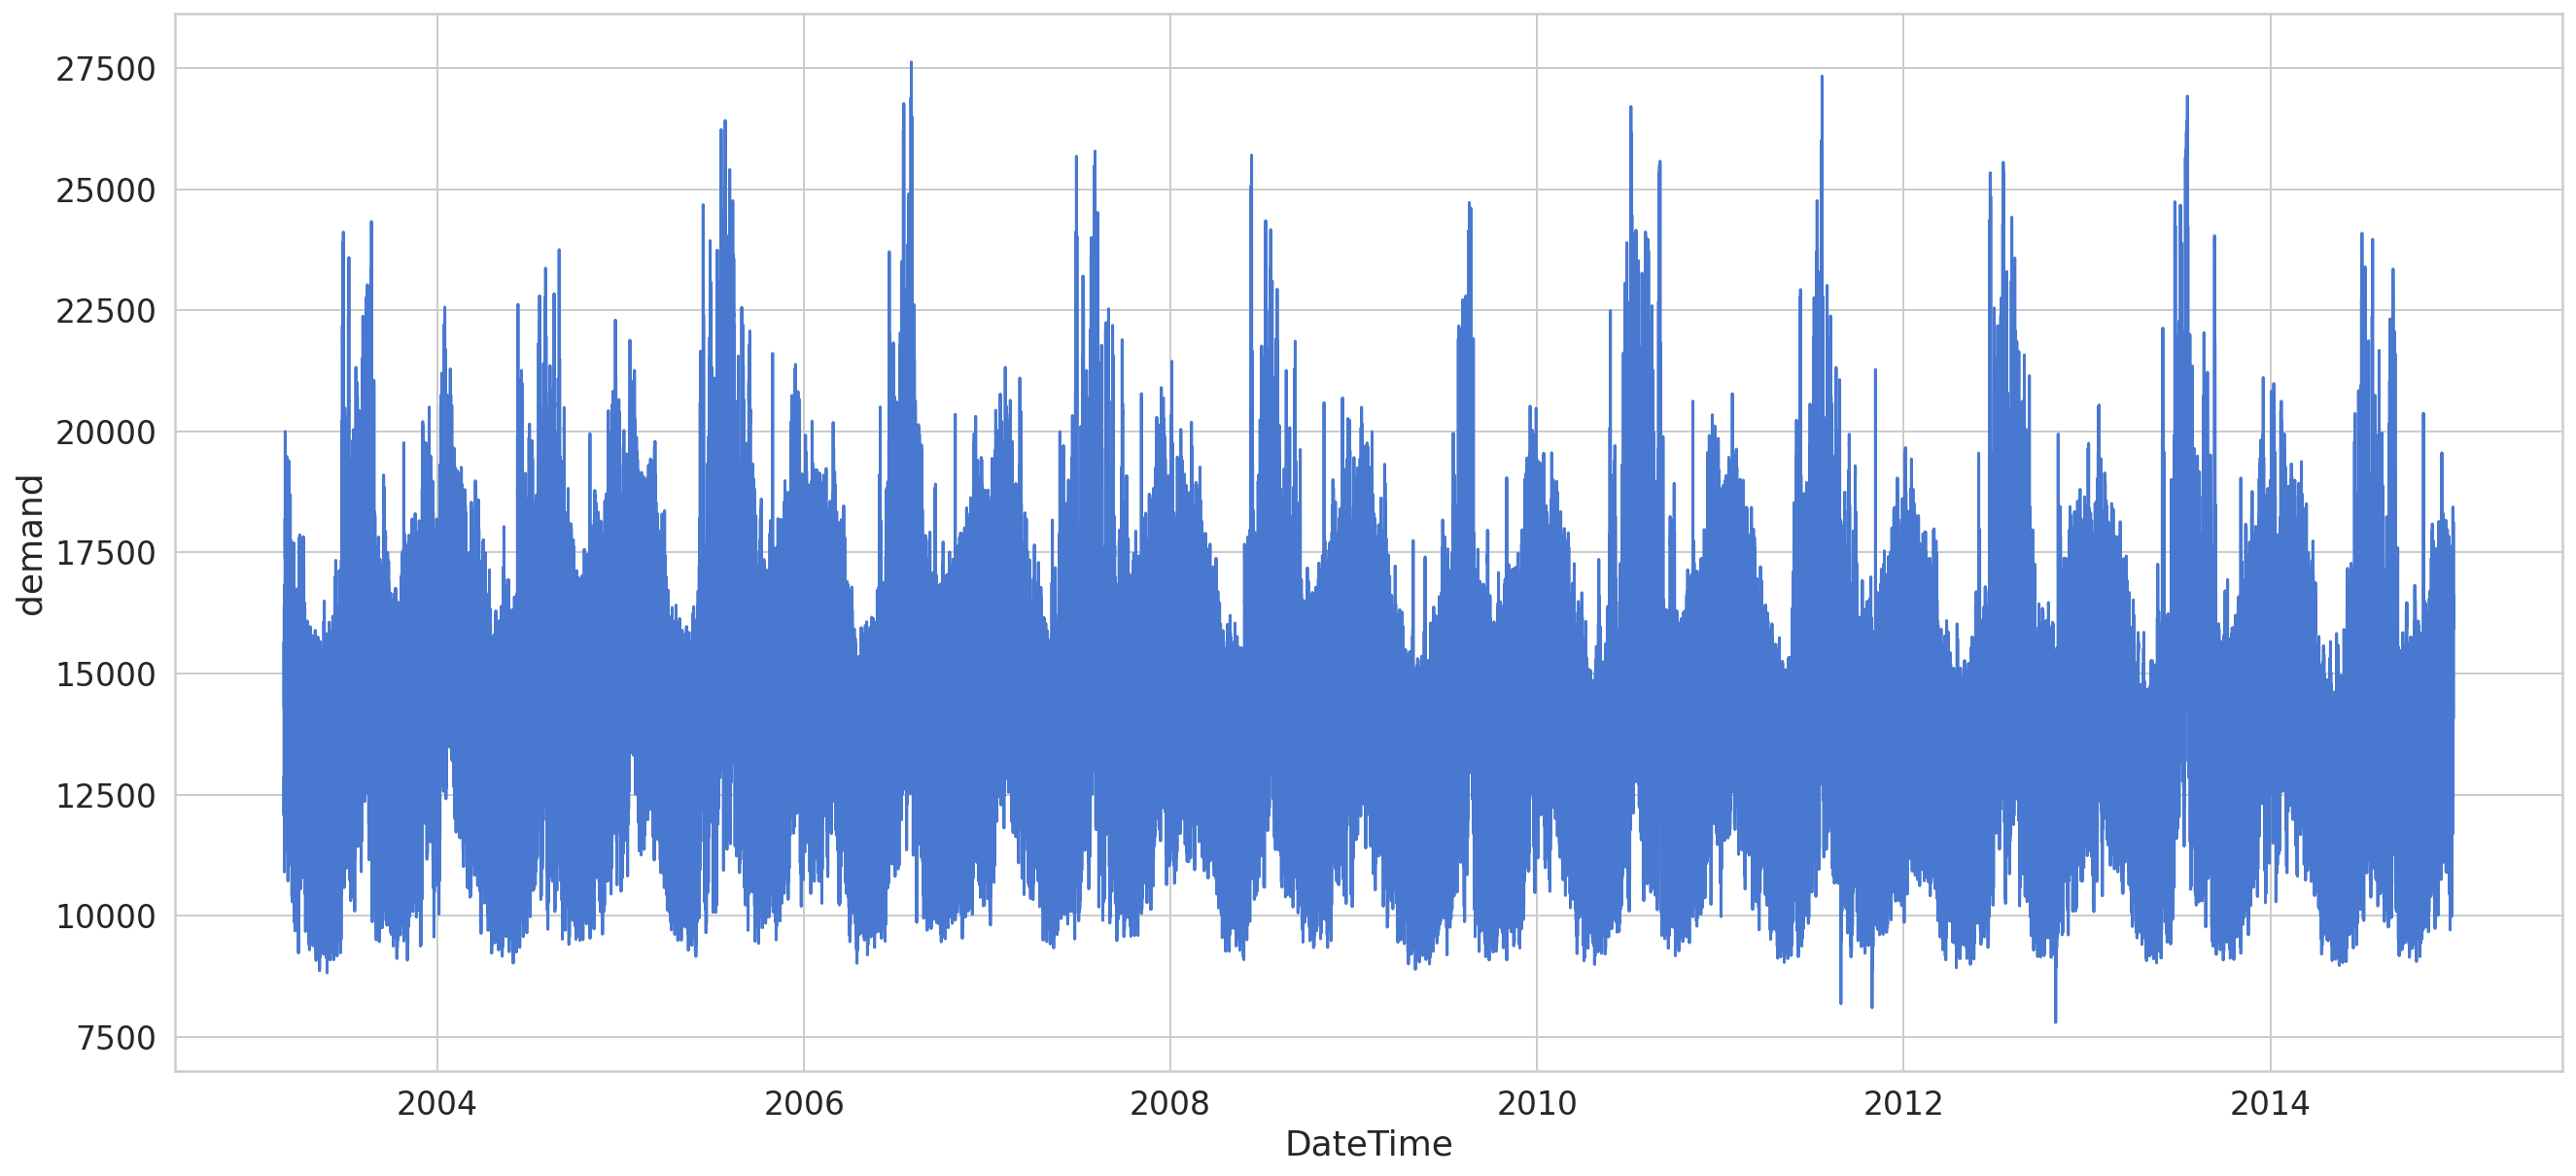

In [37]:
sns.lineplot(x=df.index, y="demand", data=df);

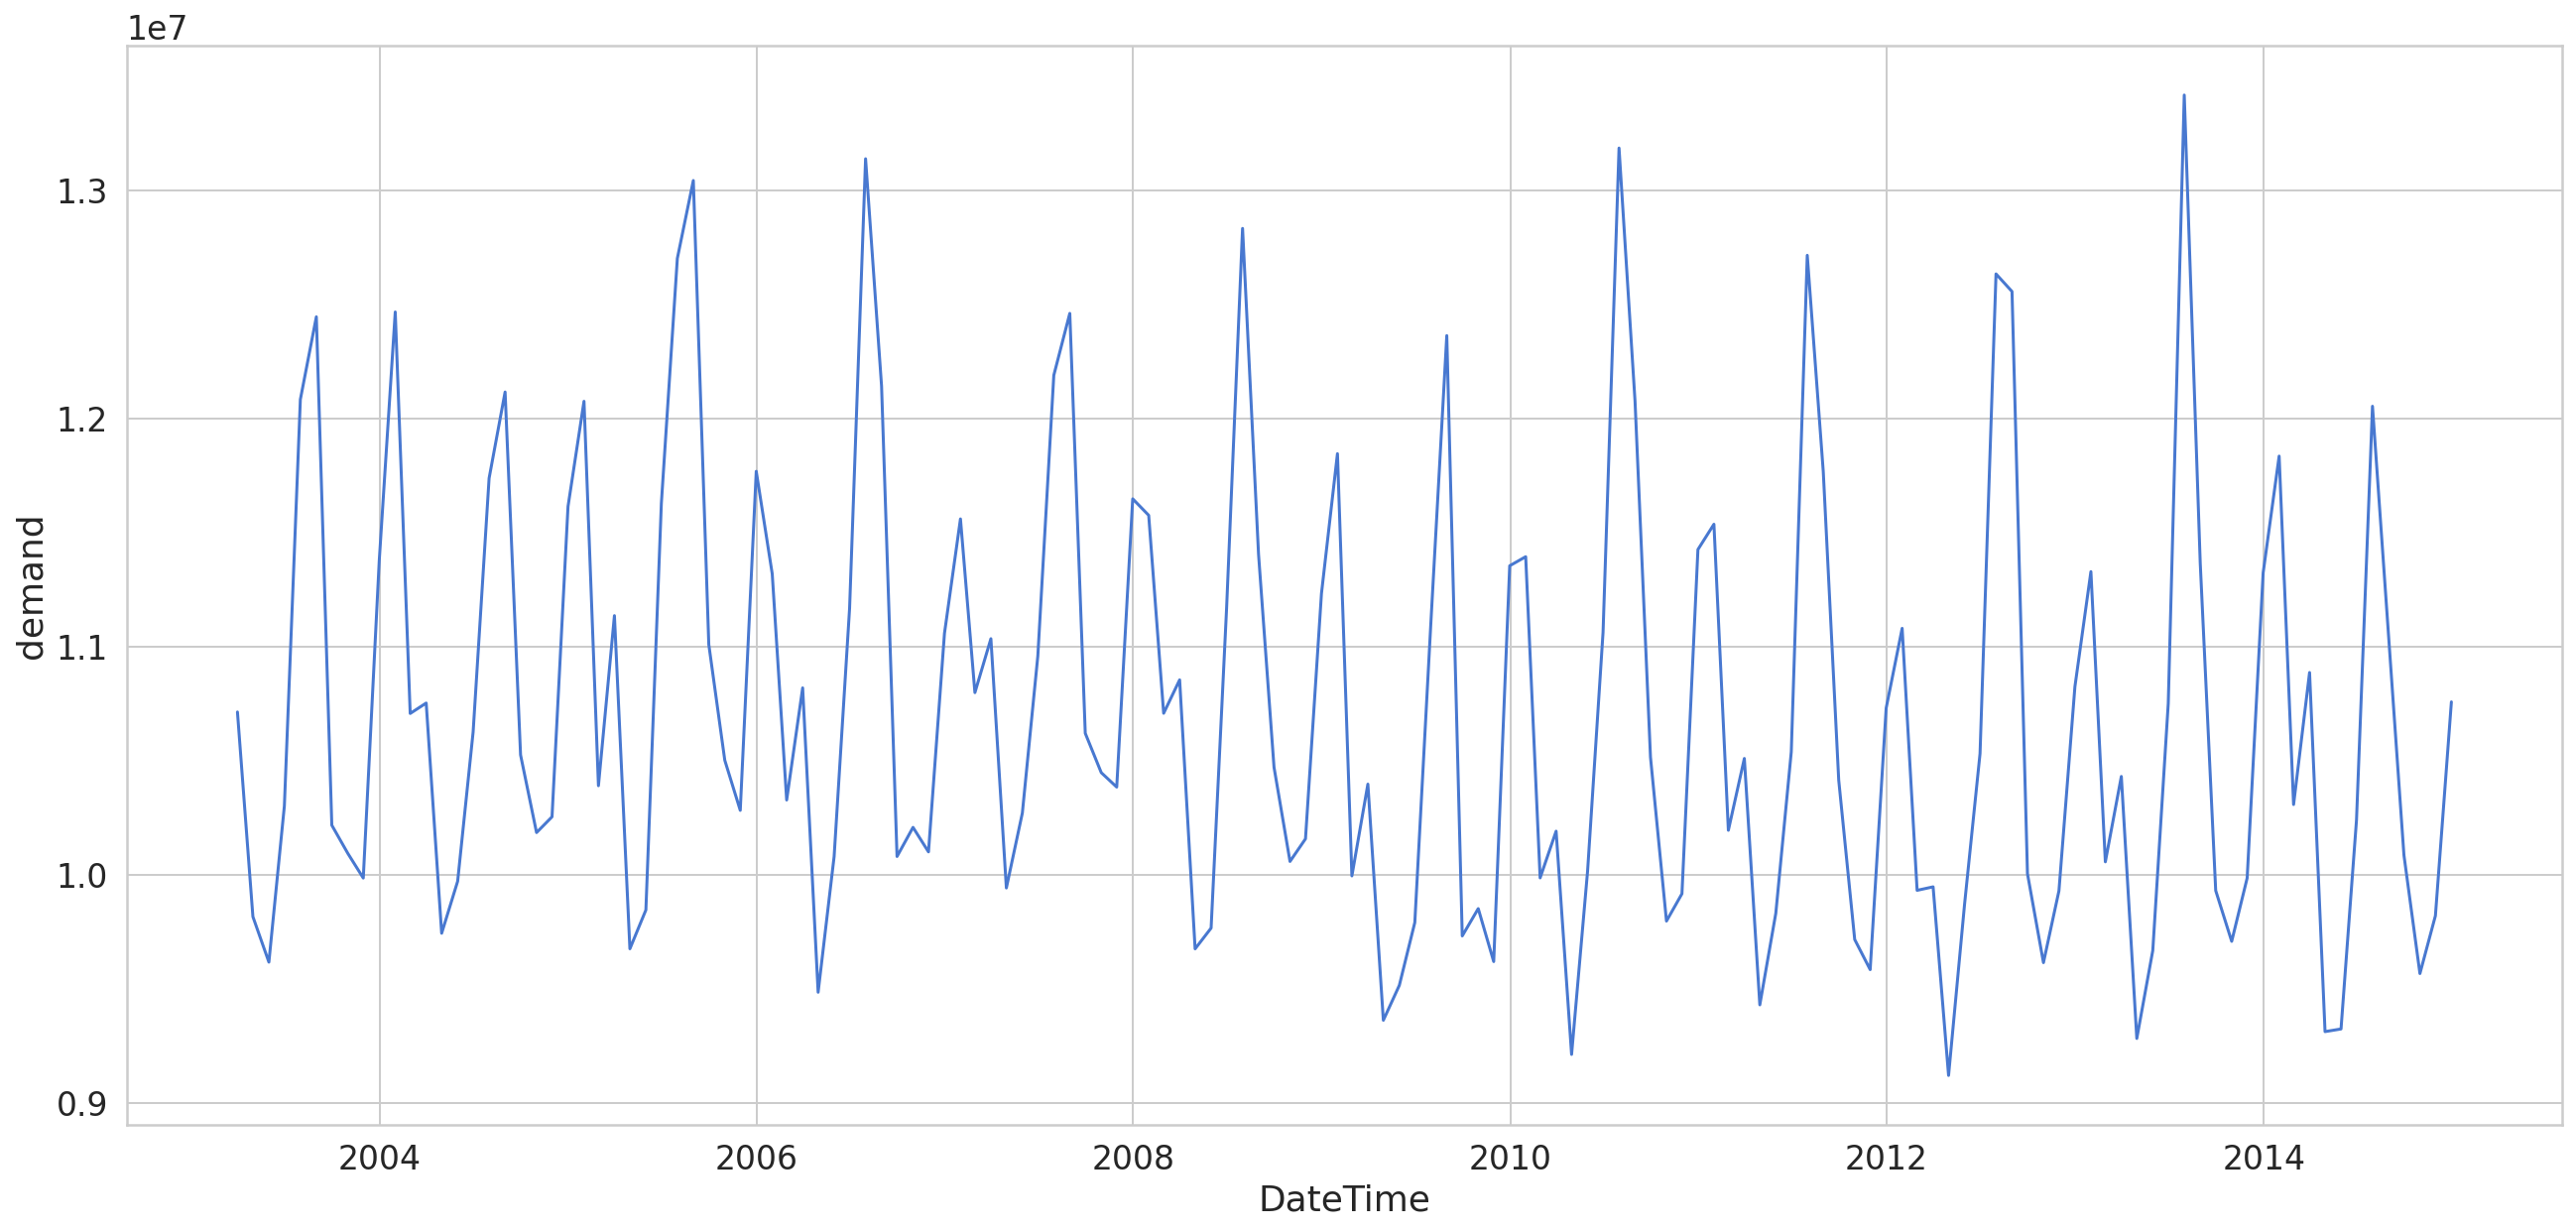

In [38]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="demand", data=df_by_month);

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["demand"],
                             model='additive'
                             )

In [40]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

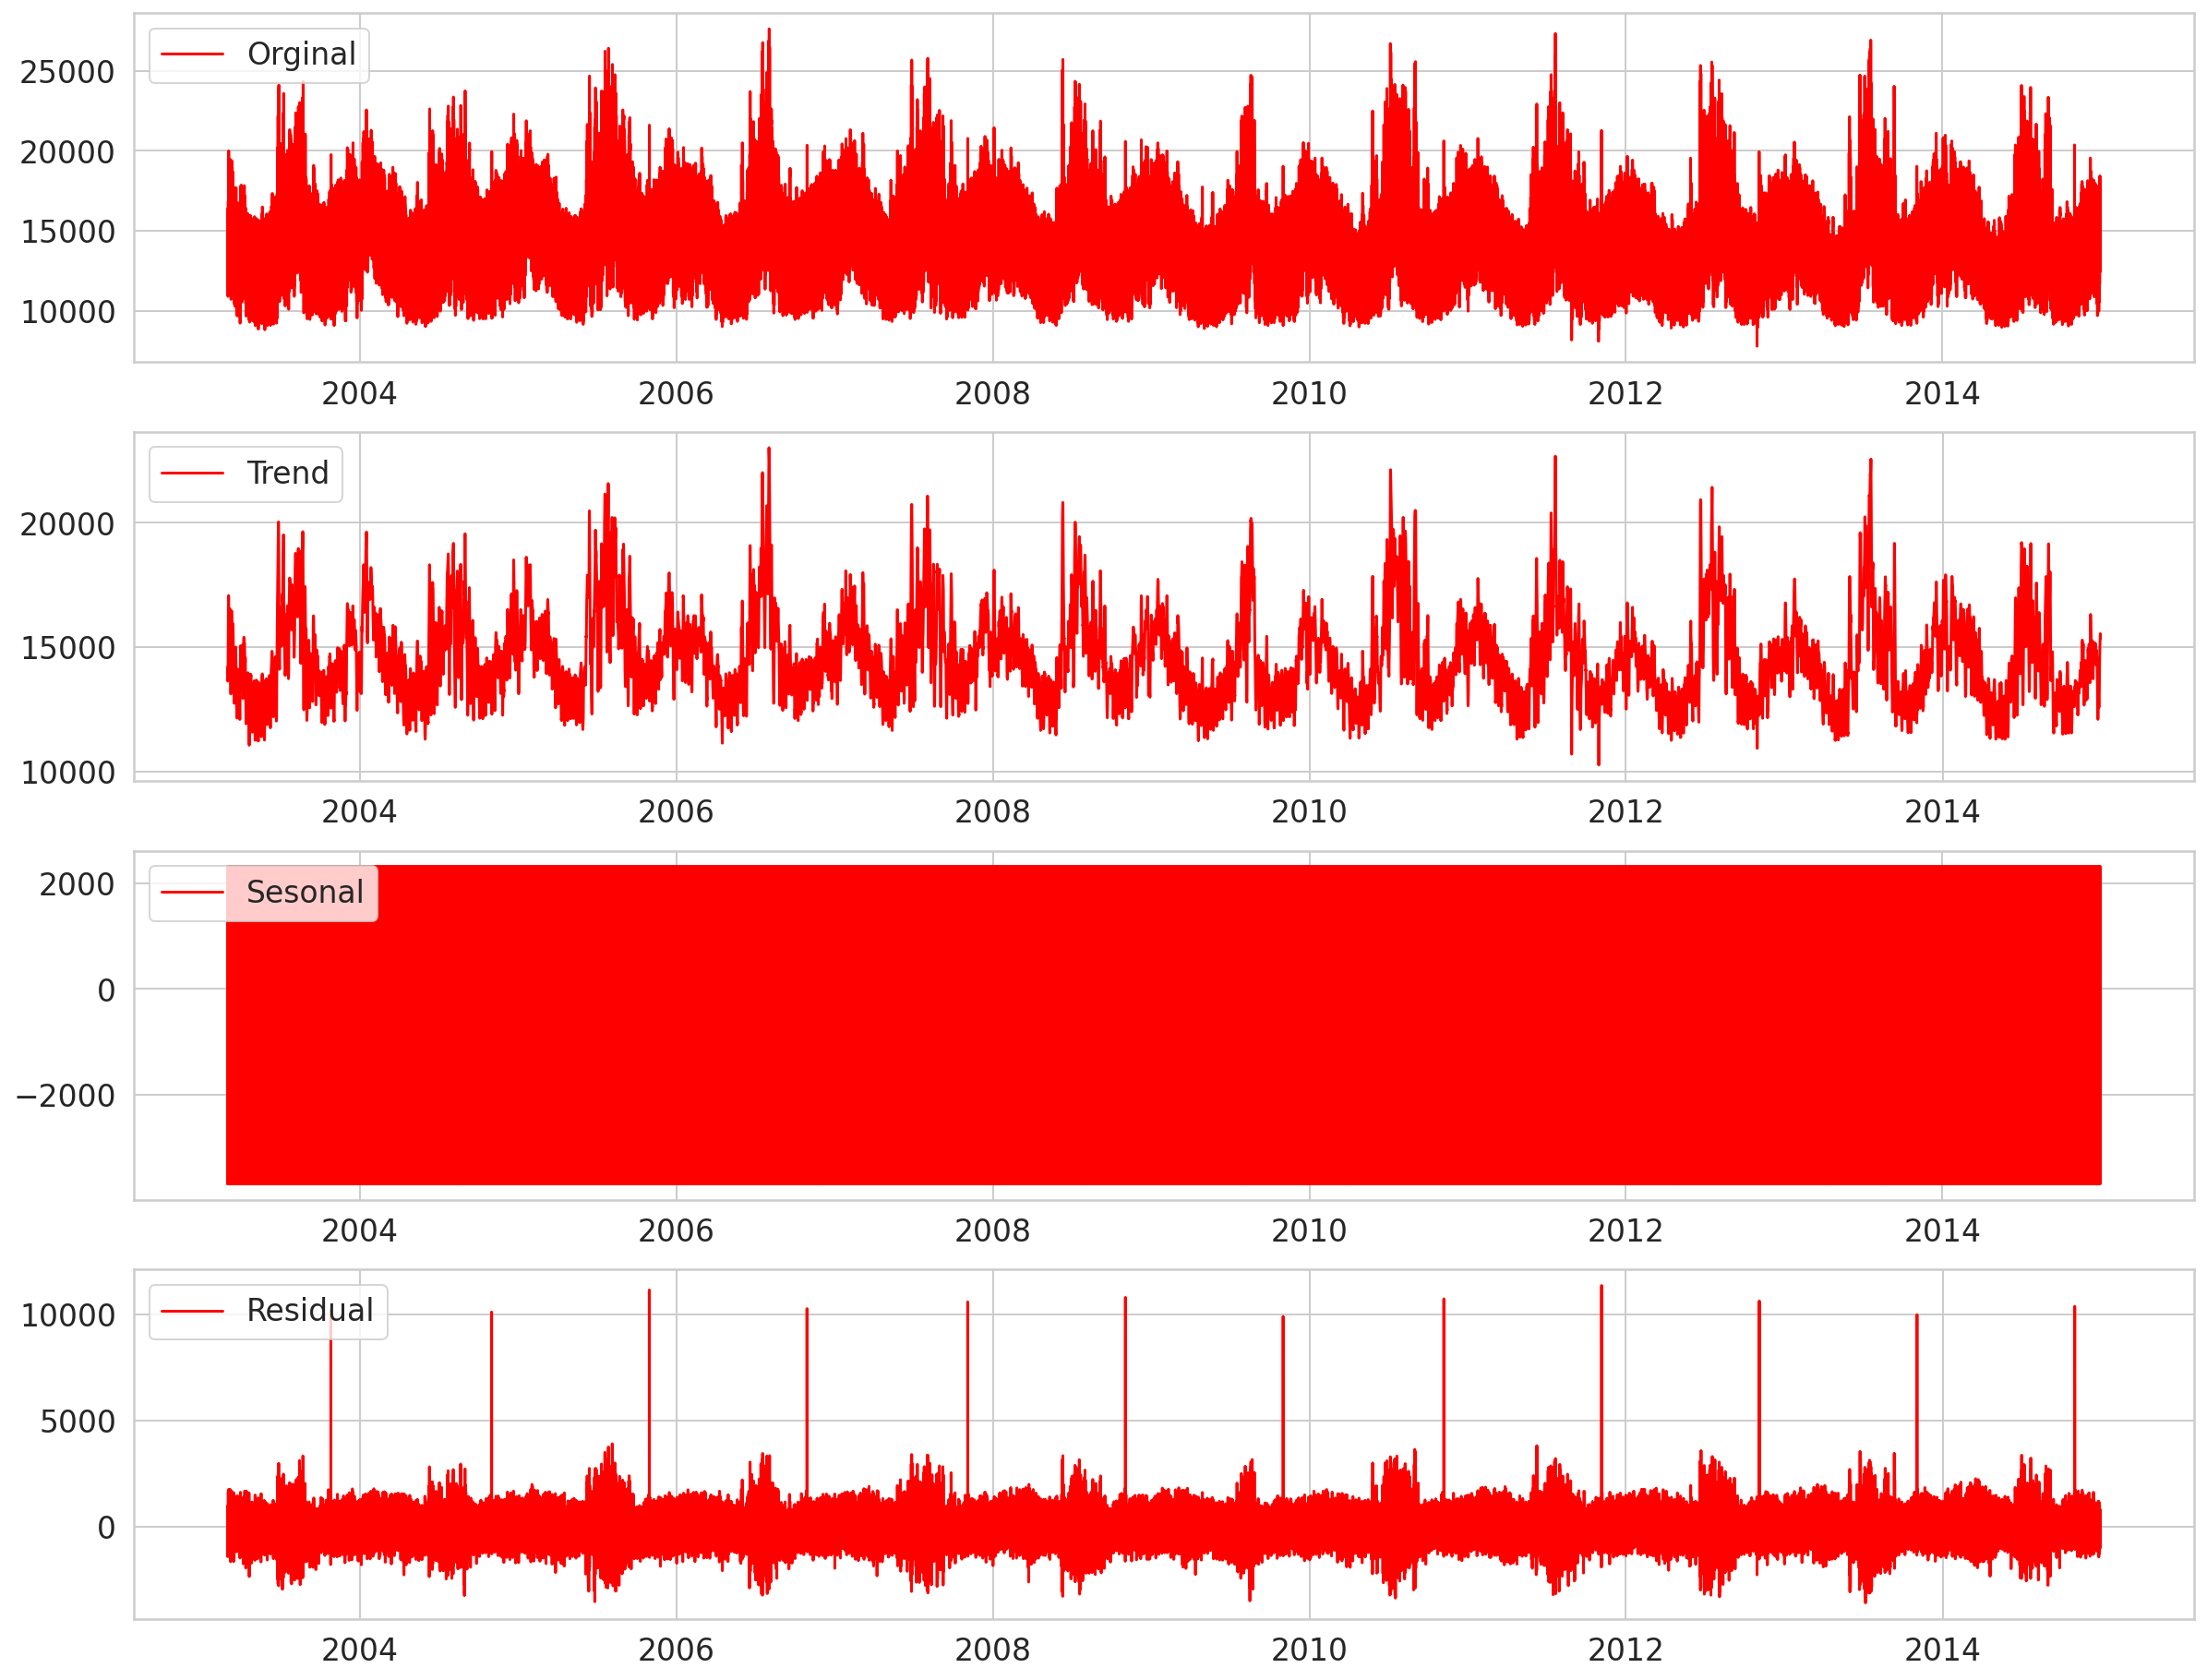

In [41]:
plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df["demand"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [42]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

93398 10378


In [43]:
from sklearn.preprocessing import RobustScaler

f_columns = ['temperature']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['demand']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['demand'] = cnt_transformer.transform(train[['demand']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['demand'] = cnt_transformer.transform(test[['demand']])

/home/venom/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-43-d99ae86935c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['demand'] = cnt_transformer.transform(train[['demand']])
/home/venom/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [44]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [46]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.demand, time_steps)
X_test, y_test = create_dataset(test, test.demand, time_steps)

print(X_train.shape, y_train.shape)

(93388, 10, 8) (93388,)


In [49]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=34, 
    validation_split=0.1,
    shuffle=False
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).